COMP9727: Recommender Systems
Assignment: Content-Based Music Recommendation
Name: Kevin Li
ZID: z5472598

# music recommender assignment

this assignment builds a recommender system for songs with 5 topics: dark, emotion, lifestyle, personal and sadness

parts:
1. topic classification
2. recommendation stuff
3. user study


In [42]:
# libs needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import string
import warnings
from IPython.display import display
warnings.filterwarnings('ignore')

# get nltk stuff
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

print("imported everything!")

imported everything!


## part 1 - topic classification

load data and check it out

In [43]:
# Load the dataset (assuming it's named 'dataset.tsv')
df = pd.read_csv('./dataset.tsv', sep='\t', encoding='utf-8')

# Display basic information about the dataset
print("Dataset Info:")
df.info()
print("\nFirst few rows:")
df.head()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artist_name   1500 non-null   object
 1   track_name    1500 non-null   object
 2   release_date  1500 non-null   int64 
 3   genre         1500 non-null   object
 4   lyrics        1500 non-null   object
 5   topic         1500 non-null   object
dtypes: int64(1), object(5)
memory usage: 70.4+ KB

First few rows:


,artist_name,track_name,release_date,genre,lyrics,topic
0,loving,the not real lake,2016,rock,awake know go see time clear world mirror worl...,dark
1,incubus,into the summer,2019,rock,shouldn summer pretty build spill ready overfl...,lifestyle
2,reignwolf,hardcore,2016,blues,lose deep catch breath think say try break wal...,sadness
3,tedeschi trucks band,anyhow,2016,blues,run bitter taste take rest feel anchor soul pl...,sadness
4,lukas nelson and promise of the real,if i started over,2017,blues,think think different set apart sober mind sym...,dark


#### Dataset columns and shape

In [44]:
print("Dataset columns:", df.columns.tolist())
print(f"Dataset shape: {df.shape}")

Dataset columns: ['artist_name', 'track_name', 'release_date', 'genre', 'lyrics', 'topic']
Dataset shape: (1500, 6)


#### Missing values

In [45]:
df.isnull().sum()

artist_name     0
track_name      0
release_date    0
genre           0
lyrics          0
topic           0
dtype: int64

#### Topic distribution

In [46]:
topic_counts = df['topic'].value_counts()
topic_counts

topic
dark         490
sadness      376
personal     347
lifestyle    205
emotion       82
Name: count, dtype: int64

#### Topic distribution visualization

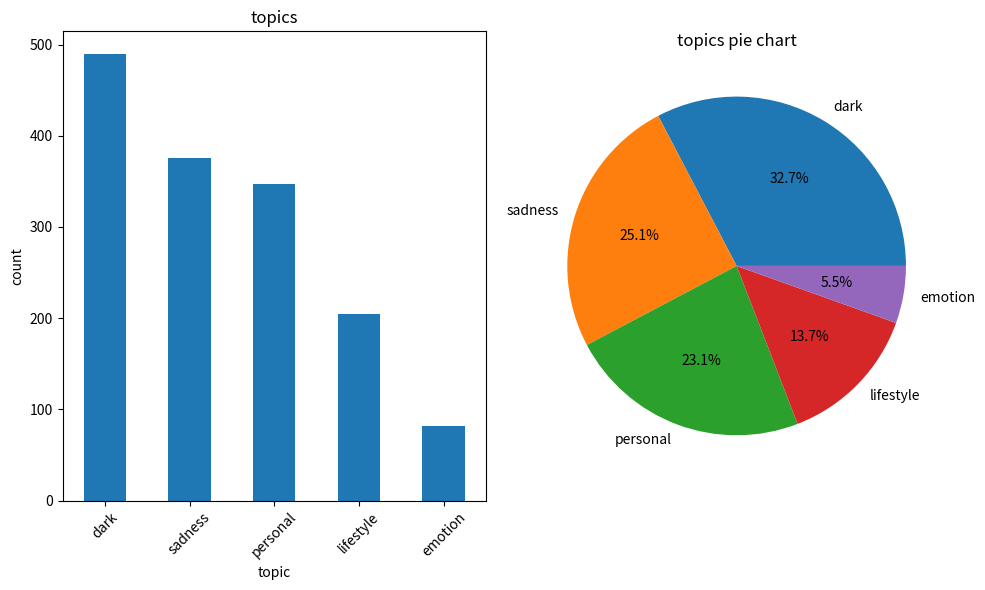


balance check:
most common: 490 songs (32.7%)
least common: 82 songs (5.5%)
not balanced


In [47]:
# Visualize topic distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
topic_counts.plot(kind='bar')
plt.title('topics')
plt.xlabel('topic')
plt.ylabel('count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(topic_counts.values, labels=topic_counts.index, autopct='%1.1f%%')
plt.title('topics pie chart')

plt.tight_layout()
plt.show()

# Check if dataset is balanced
print(f"\nbalance check:")
print(f"most common: {topic_counts.max()} songs ({topic_counts.max()/len(df)*100:.1f}%)")
print(f"least common: {topic_counts.min()} songs ({topic_counts.min()/len(df)*100:.1f}%)")

if topic_counts.max() / topic_counts.min() > 1.5:
    print("not balanced")
else:
    print("kinda balanced")

### 1.2 Text Preprocessing

**Question 1 (2 marks)**: Fix simplifications in regex and evaluation methodology

The tutorial had two main issues:
1. Regex might remove too many special characters
2. Evaluation based on single train-test split instead of cross-validation

**Solutions implemented:**
- More careful regex that preserves important punctuation and contractions
- Use stratified cross-validation for robust evaluation
- Preserve emoticons and music-specific terms

In [48]:
# preprocess text
def preprocess_text(text, do_stem=False, do_lemma=True, rm_stopwords=True):
    """makes text better"""
    if pd.isna(text):
        return ""
    
    # lowercase
    text = text.lower()
    
    # regex stuff - keep emojis and stuff
    text = re.sub(r'[^\w\s\'\-:;)(]', ' ', text)
    
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # split words
    words = word_tokenize(text)
    
    # remove stopwords if wanted
    if rm_stopwords:
        stops = set(stopwords.words('english'))
        # keep some emotion words
        emotion_words = {'not', 'no', 'never', 'nothing', 'nobody', 'nowhere'}
        stops = stops - emotion_words
        words = [w for w in words if w not in stops]
    
    # remove single chars and nums
    words = [w for w in words if len(w) > 1 and not w.isdigit()]
    
    # do stemming or lemmatization
    if do_stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(w) for w in words]
    elif do_lemma:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(w) for w in words]
    
    return ' '.join(words)

# test it
test = "I'm feeling so sad... can't believe it's over :( Never gonna be the same!!!"
processed = preprocess_text(test)
print(f"orig: {test}")
print(f"processed: {processed}")

orig: I'm feeling so sad... can't believe it's over :( Never gonna be the same!!!
processed: 'm feeling sad ca n't believe 's never gon na


#### Applying text preprocessing

In [49]:
# combine text fields
def combine_text(row):
    """puts all text together"""
    fields = [str(row['artist_name']), str(row['track_name']), str(row['genre']), str(row['lyrics'])]
    return ' '.join(fields)

# make combined text
df['combined_text'] = df.apply(combine_text, axis=1)

# process text
print("processing text...")
df['processed_text'] = df['combined_text'].apply(preprocess_text)

# remove empty ones
df = df[df['processed_text'].str.len() > 0].reset_index(drop=True)
print(f"dataset size after processing: {len(df)} songs")

# show some examples
for i in range(3):
    print(f"\nsong {i+1} - topic: {df.iloc[i]['topic']}")
    print(f"orig: {df.iloc[i]['combined_text'][:100]}...")
    print(f"processed: {df.iloc[i]['processed_text'][:100]}...")

processing text...
dataset size after processing: 1500 songs

song 1 - topic: dark
orig: loving the not real lake rock awake know go see time clear world mirror world mirror magic hour conf...
processed: loving not real lake rock awake know go see time clear world mirror world mirror magic hour confuse ...

song 2 - topic: lifestyle
orig: incubus into the summer rock shouldn summer pretty build spill ready overflow piss moan ash guess sm...
processed: incubus summer rock summer pretty build spill ready overflow piss moan ash guess smite leave remembe...

song 3 - topic: sadness
orig: reignwolf hardcore blues lose deep catch breath think say try break wall mama leave hardcore hardcor...
processed: reignwolf hardcore blue lose deep catch breath think say try break wall mama leave hardcore hardcore...


### 1.3 Question 2: Multinomial Naive Bayes Development

**Question 2 (2 marks)**: Develop Multinomial Naive Bayes and optimize preprocessing

We'll test different preprocessing combinations to find the best overall accuracy:
- Special character removal strategies
- Stopword lists (NLTK vs scikit-learn vs custom)
- Lowercasing
- Stemming vs Lemmatization

#### Testing different preprocessing combinations

In [50]:
# test different preprocessing stuff
def test_preprocessing(X, y, n_splits=5):
    """test different ways to preprocess"""
    
    # different configs to try
    configs = [
        {'do_stem': False, 'do_lemma': True, 'rm_stopwords': True, 'name': 'lemma+stop'},
        {'do_stem': True, 'do_lemma': False, 'rm_stopwords': True, 'name': 'stem+stop'},
        {'do_stem': False, 'do_lemma': False, 'rm_stopwords': True, 'name': 'basic+stop'},
        {'do_stem': False, 'do_lemma': True, 'rm_stopwords': False, 'name': 'lemma'},
        {'do_stem': True, 'do_lemma': False, 'rm_stopwords': False, 'name': 'stem'},
    ]
    
    results = []
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for config in configs:
        print(f"\ntesting: {config['name']}")
        
        # preprocess text
        processed = [preprocess_text(text, **{k:v for k,v in config.items() if k != 'name'}) 
                    for text in X]
        
        # vectorize
        vec = CountVectorizer(max_features=5000, ngram_range=(1,2))
        X_vec = vec.fit_transform(processed)
        
        # try both naive bayes
        for nb_type, nb in [('bernoulli', BernoulliNB()), ('multinomial', MultinomialNB())]:
            scores = cross_val_score(nb, X_vec, y, cv=cv, scoring='accuracy')
            results.append({
                'preprocess': config['name'],
                'model': nb_type,
                'mean_acc': scores.mean(),
                'std_acc': scores.std()
            })
            print(f"{nb_type} nb - acc: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")
    
    return pd.DataFrame(results)

# run preprocessing tests
X_text = df['combined_text'].values
y = df['topic'].values

preprocess_results = test_preprocessing(X_text, y)


testing: lemma+stop
bernoulli nb - acc: 0.6213 (+/- 0.0300)
multinomial nb - acc: 0.8200 (+/- 0.0260)

testing: stem+stop
bernoulli nb - acc: 0.6193 (+/- 0.0247)
multinomial nb - acc: 0.8160 (+/- 0.0351)

testing: basic+stop
bernoulli nb - acc: 0.6247 (+/- 0.0381)
multinomial nb - acc: 0.8133 (+/- 0.0400)

testing: lemma
bernoulli nb - acc: 0.6227 (+/- 0.0449)
multinomial nb - acc: 0.8160 (+/- 0.0445)

testing: stem
bernoulli nb - acc: 0.6160 (+/- 0.0346)
multinomial nb - acc: 0.8140 (+/- 0.0330)


#### Preprocessing Results Summary

In [51]:
display(preprocess_results.round(4))

# Find best preprocessing combination
best_config = preprocess_results.loc[preprocess_results['mean_acc'].idxmax()]
print(f"\nBest configuration: {best_config['preprocess']} with {best_config['model']} NB")
print(f"Best accuracy: {best_config['mean_acc']:.4f} (+/- {best_config['std_acc']*2:.4f})")

,preprocess,model,mean_acc,std_acc
0,lemma+stop,bernoulli,0.6213,0.0150
1,lemma+stop,multinomial,0.8200,0.0130
2,stem+stop,bernoulli,0.6193,0.0124
3,stem+stop,multinomial,0.8160,0.0176
4,basic+stop,bernoulli,0.6247,0.0190
5,basic+stop,multinomial,0.8133,0.0200
6,lemma,bernoulli,0.6227,0.0224
7,lemma,multinomial,0.8160,0.0223
8,stem,bernoulli,0.6160,0.0173
9,stem,multinomial,0.8140,0.0165



Best configuration: lemma+stop with multinomial NB
Best accuracy: 0.8200 (+/- 0.0260)


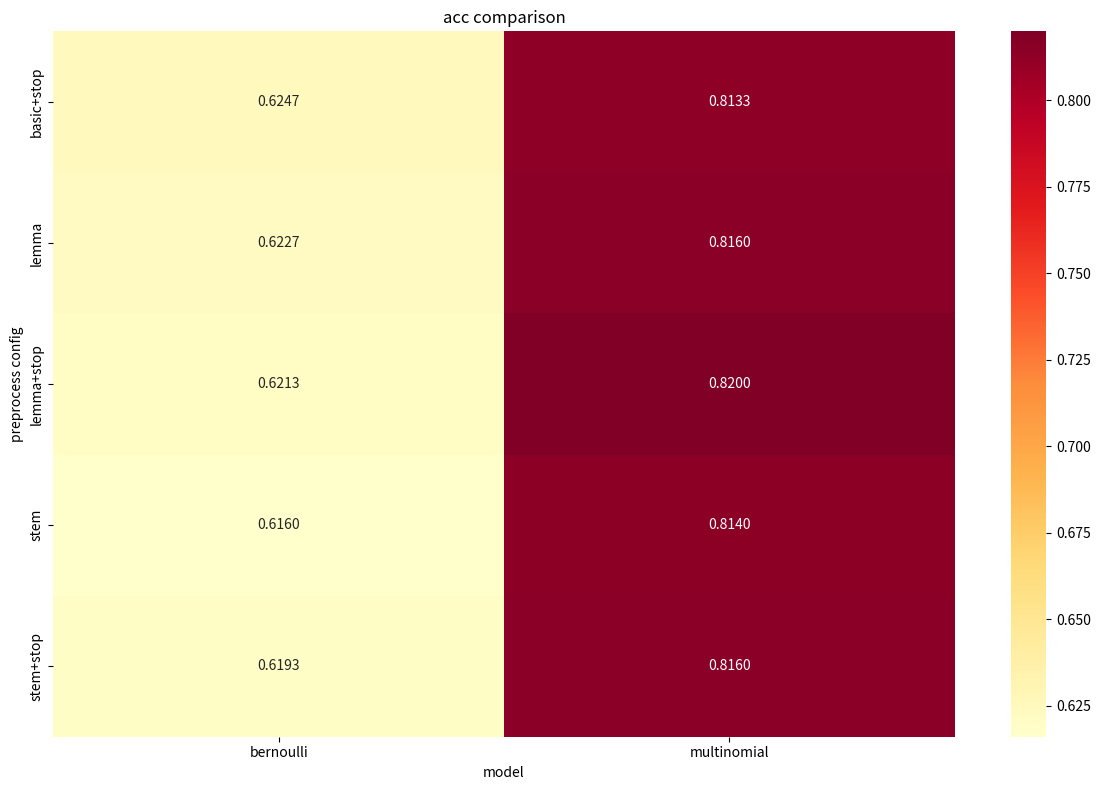

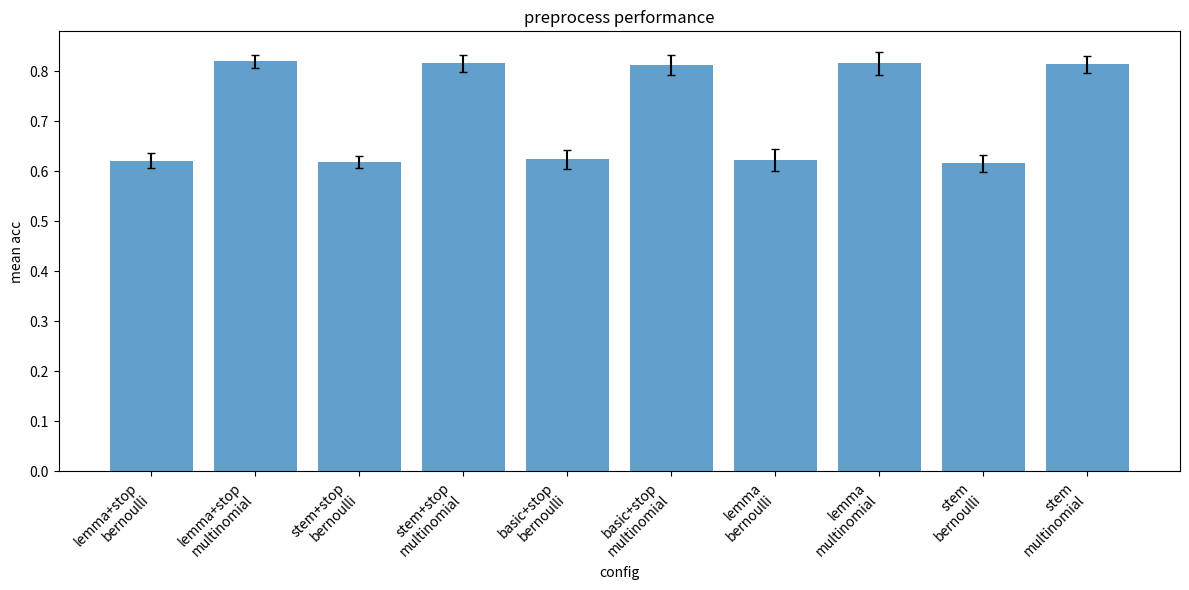


using lemma + stopwords for the rest


In [52]:
# plot results
plt.figure(figsize=(12, 8))

# pivot for heatmap
pivot_results = preprocess_results.pivot(index='preprocess', columns='model', values='mean_acc')

# heatmap
sns.heatmap(pivot_results, annot=True, fmt='.4f', cmap='YlOrRd')
plt.title('acc comparison')
plt.xlabel('model')
plt.ylabel('preprocess config')
plt.tight_layout()
plt.show()

# bar plot
plt.figure(figsize=(12, 6))
x_pos = np.arange(len(preprocess_results))
plt.bar(x_pos, preprocess_results['mean_acc'], 
        yerr=preprocess_results['std_acc'],
        alpha=0.7, capsize=3)
plt.xlabel('config')
plt.ylabel('mean acc')
plt.title('preprocess performance')
plt.xticks(x_pos, [f"{row['preprocess']}\n{row['model']}" for _, row in preprocess_results.iterrows()], 
           rotation=45, ha='right')
plt.tight_layout()
plt.show()

# use best preprocessing for rest of assignment
best_preprocessing = lambda text: preprocess_text(text, do_lemma=True, rm_stopwords=True)
df['final_processed_text'] = df['combined_text'].apply(best_preprocessing)
print(f"\nusing lemma + stopwords for the rest")

### 1.4 Question 3: Model Comparison with Cross-Validation

**Question 3 (2 marks)**: Compare BNB and MNB using full dataset with cross-validation

We'll evaluate both models using appropriate metrics considering dataset balance.
For balanced datasets: accuracy, macro-averaged F1
For imbalanced datasets: weighted F1, precision, recall per class

#### Model Comparison with Cross-Validation

In [53]:
# Comprehensive model evaluation function
def evaluate_models_cross_validation(X, y, models, cv_folds=5):
    """
    Evaluate multiple models using cross-validation with multiple metrics
    """
    results = {}
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # Define metrics based on dataset balance
    topic_counts = pd.Series(y).value_counts()
    is_balanced = (topic_counts.max() / topic_counts.min()) <= 1.5
    
    print(f"Dataset is {'balanced' if is_balanced else 'imbalanced'}")
    
    metrics = ['accuracy']
    if is_balanced:
        metrics.extend(['f1_macro', 'precision_macro', 'recall_macro'])
    else:
        metrics.extend(['f1_weighted', 'precision_weighted', 'recall_weighted'])
    
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}...")
        model_results = {}
        
        for metric in metrics:
            scores = cross_val_score(model, X, y, cv=skf, scoring=metric)
            model_results[metric] = {
                'mean': scores.mean(),
                'std': scores.std(),
                'scores': scores
            }
            print(f"{metric}: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")
        
        results[model_name] = model_results
    
    return results

# Prepare data with best preprocessing
vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,2))
X_processed = vectorizer.fit_transform(df['final_processed_text'])

# Define models to compare
models = {
    'Bernoulli Naive Bayes': BernoulliNB(),
    'Multinomial Naive Bayes': MultinomialNB()
}

# Run comprehensive evaluation
evaluation_results = evaluate_models_cross_validation(X_processed, y, models)

Dataset is imbalanced

Evaluating Bernoulli Naive Bayes...
accuracy: 0.6213 (+/- 0.0300)
f1_weighted: 0.5855 (+/- 0.0296)
precision_weighted: 0.6478 (+/- 0.0460)
recall_weighted: 0.6213 (+/- 0.0300)

Evaluating Multinomial Naive Bayes...
accuracy: 0.8200 (+/- 0.0260)
f1_weighted: 0.8213 (+/- 0.0247)
precision_weighted: 0.8253 (+/- 0.0221)
recall_weighted: 0.8200 (+/- 0.0260)


#### Detailed Results Summary

,Model,Metric,Mean,Std
0,Bernoulli Naive Bayes,accuracy,0.6213,0.0150
1,Bernoulli Naive Bayes,f1_weighted,0.5855,0.0148
2,Bernoulli Naive Bayes,precision_weighted,0.6478,0.0230
3,Bernoulli Naive Bayes,recall_weighted,0.6213,0.0150
4,Multinomial Naive Bayes,accuracy,0.8200,0.0130
5,Multinomial Naive Bayes,f1_weighted,0.8213,0.0123
6,Multinomial Naive Bayes,precision_weighted,0.8253,0.0110
7,Multinomial Naive Bayes,recall_weighted,0.8200,0.0130


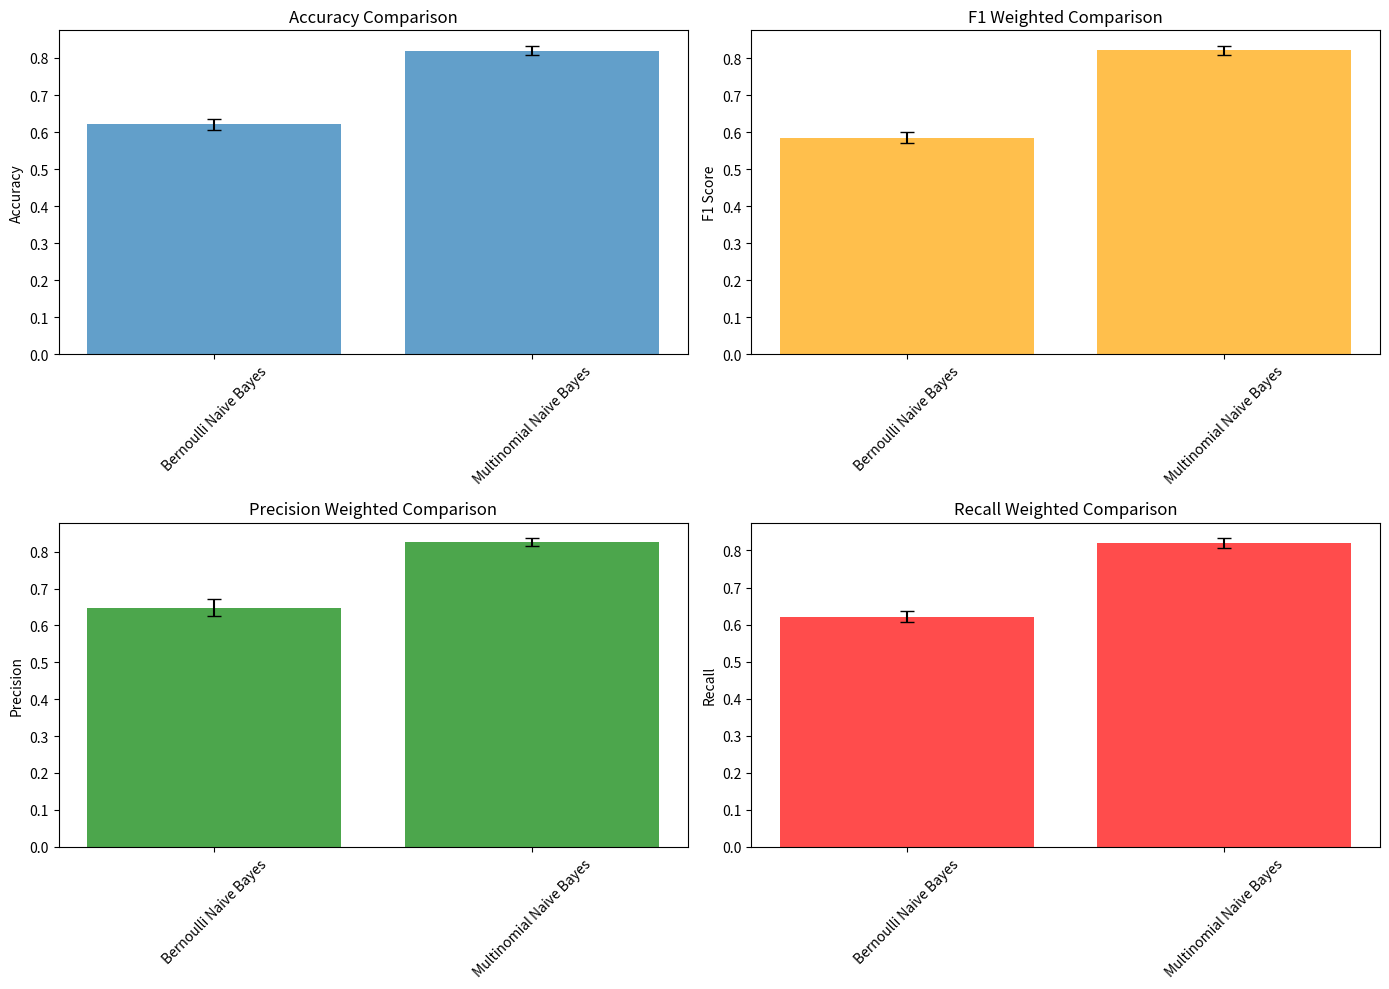

t-statistic: -22.9231, p-value: 0.0000
Significant difference found. Multinomial NB performs better.


In [54]:
# Create detailed results summary and visualizations
results_df = []
for model_name, metrics in evaluation_results.items():
    for metric_name, metric_data in metrics.items():
        results_df.append({
            'Model': model_name,
            'Metric': metric_name,
            'Mean': metric_data['mean'],
            'Std': metric_data['std']
        })

results_df = pd.DataFrame(results_df)
display(results_df.round(4))

# Visualize results
plt.figure(figsize=(14, 10))

# Subplot 1: Accuracy comparison
plt.subplot(2, 2, 1)
accuracy_data = results_df[results_df['Metric'] == 'accuracy']
plt.bar(accuracy_data['Model'], accuracy_data['Mean'], yerr=accuracy_data['Std'], capsize=5, alpha=0.7)
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# Subplot 2: F1 Score comparison  
plt.subplot(2, 2, 2)
f1_metric = 'f1_macro' if (df['topic'].value_counts().max() / df['topic'].value_counts().min()) <= 1.5 else 'f1_weighted'
f1_data = results_df[results_df['Metric'] == f1_metric]
plt.bar(f1_data['Model'], f1_data['Mean'], yerr=f1_data['Std'], capsize=5, alpha=0.7, color='orange')
plt.title(f'{f1_metric.replace("_", " ").title()} Comparison')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)

# Subplot 3: Precision comparison
plt.subplot(2, 2, 3)
prec_metric = 'precision_macro' if (df['topic'].value_counts().max() / df['topic'].value_counts().min()) <= 1.5 else 'precision_weighted'
prec_data = results_df[results_df['Metric'] == prec_metric]
plt.bar(prec_data['Model'], prec_data['Mean'], yerr=prec_data['Std'], capsize=5, alpha=0.7, color='green')
plt.title(f'{prec_metric.replace("_", " ").title()} Comparison')
plt.ylabel('Precision')
plt.xticks(rotation=45)

# Subplot 4: Recall comparison
plt.subplot(2, 2, 4)
rec_metric = 'recall_macro' if (df['topic'].value_counts().max() / df['topic'].value_counts().min()) <= 1.5 else 'recall_weighted'
rec_data = results_df[results_df['Metric'] == rec_metric]
plt.bar(rec_data['Model'], rec_data['Mean'], yerr=rec_data['Std'], capsize=5, alpha=0.7, color='red')
plt.title(f'{rec_metric.replace("_", " ").title()} Comparison')
plt.ylabel('Recall')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Statistical significance test (if needed)
from scipy import stats
bnb_accuracy = evaluation_results['Bernoulli Naive Bayes']['accuracy']['scores']
mnb_accuracy = evaluation_results['Multinomial Naive Bayes']['accuracy']['scores']
t_stat, p_value = stats.ttest_rel(bnb_accuracy, mnb_accuracy)
print(f"t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

if p_value < 0.05:
    winner = 'Multinomial NB' if mnb_accuracy.mean() > bnb_accuracy.mean() else 'Bernoulli NB'
    print(f"Significant difference found. {winner} performs better.")
else:
    print("No significant difference between models.")

### 1.5 Question 4: Feature Number Optimization

**Question 4 (2 marks)**: Optimize the number of features (words) used in classification

We'll test different values of max_features in CountVectorizer to find the optimal number.

#### Feature Number Optimization


testing 500 features...
Bernoulli Naive Bayes - acc: 0.6787, f1: 0.6721
Multinomial Naive Bayes - acc: 0.8567, f1: 0.8563

testing 1000 features...
Bernoulli Naive Bayes - acc: 0.6820, f1: 0.6716
Multinomial Naive Bayes - acc: 0.8393, f1: 0.8395

testing 2000 features...
Bernoulli Naive Bayes - acc: 0.6687, f1: 0.6477
Multinomial Naive Bayes - acc: 0.8253, f1: 0.8258

testing 3000 features...
Bernoulli Naive Bayes - acc: 0.6533, f1: 0.6275
Multinomial Naive Bayes - acc: 0.8280, f1: 0.8286

testing 5000 features...
Bernoulli Naive Bayes - acc: 0.6213, f1: 0.5855
Multinomial Naive Bayes - acc: 0.8200, f1: 0.8213

testing 7500 features...
Bernoulli Naive Bayes - acc: 0.5767, f1: 0.5262
Multinomial Naive Bayes - acc: 0.8187, f1: 0.8201

testing 10000 features...
Bernoulli Naive Bayes - acc: 0.5540, f1: 0.5004
Multinomial Naive Bayes - acc: 0.8160, f1: 0.8172

testing 15000 features...
Bernoulli Naive Bayes - acc: 0.5180, f1: 0.4565
Multinomial Naive Bayes - acc: 0.8173, f1: 0.8179

testin

,n_features,model,acc_mean,acc_std,f1_mean,f1_std
0,500,Bernoulli Naive Bayes,0.6787,0.0195,0.6721,0.0163
1,500,Multinomial Naive Bayes,0.8567,0.0203,0.8563,0.0207
2,1000,Bernoulli Naive Bayes,0.6820,0.0177,0.6716,0.0176
3,1000,Multinomial Naive Bayes,0.8393,0.0100,0.8395,0.0105
4,2000,Bernoulli Naive Bayes,0.6687,0.0141,0.6477,0.0157
5,2000,Multinomial Naive Bayes,0.8253,0.0136,0.8258,0.0139
6,3000,Bernoulli Naive Bayes,0.6533,0.0183,0.6275,0.0174
7,3000,Multinomial Naive Bayes,0.8280,0.0107,0.8286,0.0106
8,5000,Bernoulli Naive Bayes,0.6213,0.0150,0.5855,0.0148
9,5000,Multinomial Naive Bayes,0.8200,0.0130,0.8213,0.0123


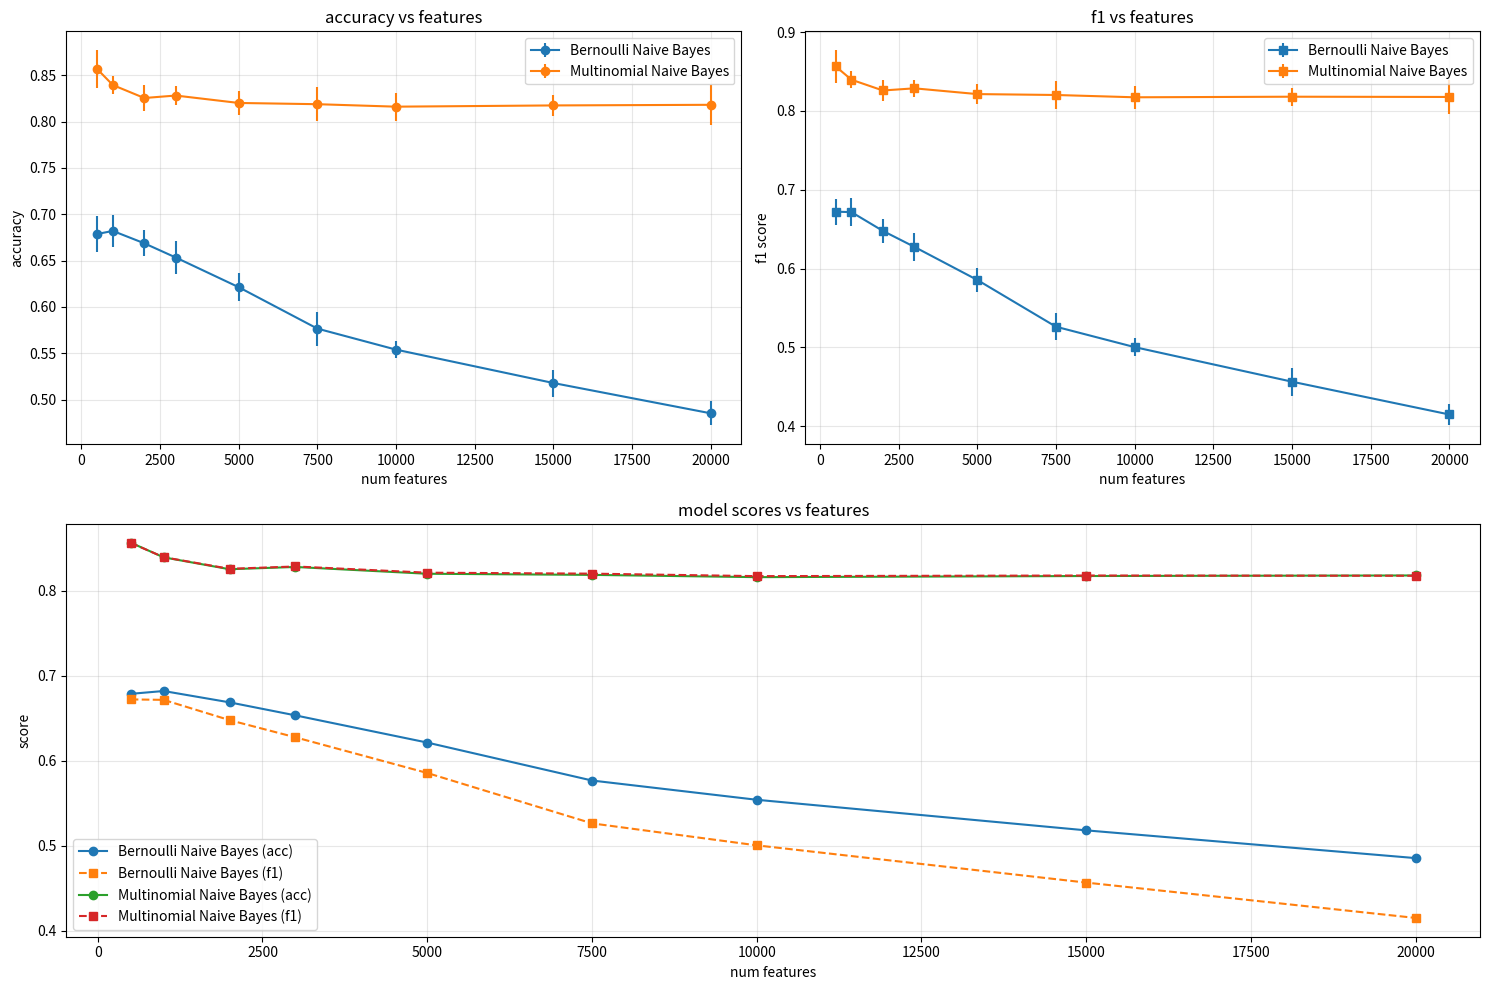


best setup:
features: 500
model: Multinomial Naive Bayes
accuracy: 0.8567 (+/- 0.0407)
f1: 0.8563 (+/- 0.0414)

using 500 features for rest


In [55]:
# try different numbers of features
def test_features(texts, labels, feature_nums, models, cv_splits=5):
    """test different feature counts"""
    
    results = []
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    
    for n_feat in feature_nums:
        print(f"\ntesting {n_feat} features...")
        
        # make vectorizer
        vec = CountVectorizer(max_features=n_feat, ngram_range=(1,2))
        X_vec = vec.fit_transform(texts)
        
        for model_name, model in models.items():
            # do cross val
            acc = cross_val_score(model, X_vec, labels, cv=cv, scoring='accuracy')
            f1 = cross_val_score(model, X_vec, labels, cv=cv, scoring='f1_weighted')
            
            results.append({
                'n_features': n_feat,
                'model': model_name,
                'acc_mean': acc.mean(),
                'acc_std': acc.std(),
                'f1_mean': f1.mean(),
                'f1_std': f1.std()
            })
            
            print(f"{model_name} - acc: {acc.mean():.4f}, f1: {f1.mean():.4f}")
    
    return pd.DataFrame(results)

# test feature counts
feature_nums = [500, 1000, 2000, 3000, 5000, 7500, 10000, 15000, 20000]
feature_results = test_features(df['final_processed_text'], y, feature_nums, models)

# show results
display(feature_results.round(4))

# plot stuff
plt.figure(figsize=(15, 10))

# acc vs features
plt.subplot(2, 2, 1)
for model_name in models.keys():
    model_data = feature_results[feature_results['model'] == model_name]
    plt.errorbar(model_data['n_features'], model_data['acc_mean'], 
                yerr=model_data['acc_std'], label=model_name, marker='o')
plt.xlabel('num features')
plt.ylabel('accuracy')
plt.title('accuracy vs features')
plt.legend()
plt.grid(True, alpha=0.3)

# f1 vs features
plt.subplot(2, 2, 2)
for model_name in models.keys():
    model_data = feature_results[feature_results['model'] == model_name]
    plt.errorbar(model_data['n_features'], model_data['f1_mean'], 
                yerr=model_data['f1_std'], label=model_name, marker='s')
plt.xlabel('num features')
plt.ylabel('f1 score')
plt.title('f1 vs features')
plt.legend()
plt.grid(True, alpha=0.3)

# both metrics
plt.subplot(2, 1, 2)
for model_name in models.keys():
    model_data = feature_results[feature_results['model'] == model_name]
    plt.plot(model_data['n_features'], model_data['acc_mean'], 
            label=f'{model_name} (acc)', marker='o', linestyle='-')
    plt.plot(model_data['n_features'], model_data['f1_mean'], 
            label=f'{model_name} (f1)', marker='s', linestyle='--')

plt.xlabel('num features')
plt.ylabel('score')
plt.title('model scores vs features')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# find best
best = feature_results.loc[feature_results['acc_mean'].idxmax()]
print(f"\nbest setup:")
print(f"features: {best['n_features']}")
print(f"model: {best['model']}")
print(f"accuracy: {best['acc_mean']:.4f} (+/- {best['acc_std']*2:.4f})")
print(f"f1: {best['f1_mean']:.4f} (+/- {best['f1_std']*2:.4f})")

# use best features
best_features = best['n_features']
print(f"\nusing {best_features} features for rest")

### q5 - random forest

try random forest cuz:
1. good for text
2. shows important features
3. doesnt overfit much
4. good for music stuff
5. can do non-linear stuff

### 1.6 Question 5: Third Machine Learning Method

**Question 5 (5 marks)**: Implement and evaluate a third machine learning method

**Selected Method: Random Forest Classifier**

**Rationale:** Random Forest is suitable for text classification because:
1. Handles high-dimensional sparse data well (common in text)
2. Provides feature importance rankings
3. Robust to overfitting through ensemble averaging
4. Commonly used for music/audio classification tasks
5. Can capture non-linear relationships between features

**Hypothesis:** Random Forest will outperform Naive Bayes models due to its ability 
to capture feature interactions and non-linear patterns in the text data.

#### Random Forest Implementation and Tuning

tuning random forest...
best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
best score: 0.7007

evaluating bernoulli nb...
accuracy: 0.6787 (+/- 0.0390)
f1_weighted: 0.6721 (+/- 0.0327)
precision_weighted: 0.6754 (+/- 0.0417)
recall_weighted: 0.6787 (+/- 0.0390)

evaluating multinomial nb...
accuracy: 0.8567 (+/- 0.0407)
f1_weighted: 0.8563 (+/- 0.0414)
precision_weighted: 0.8594 (+/- 0.0424)
recall_weighted: 0.8567 (+/- 0.0407)

evaluating random forest...
accuracy: 0.7133 (+/- 0.0337)
f1_weighted: 0.6954 (+/- 0.0327)
precision_weighted: 0.7196 (+/- 0.0586)
recall_weighted: 0.7133 (+/- 0.0337)

final results:


,model,metric,mean,std
0,bernoulli nb,accuracy,0.6787,0.0195
1,bernoulli nb,f1_weighted,0.6721,0.0163
2,bernoulli nb,precision_weighted,0.6754,0.0209
3,bernoulli nb,recall_weighted,0.6787,0.0195
4,multinomial nb,accuracy,0.8567,0.0203
5,multinomial nb,f1_weighted,0.8563,0.0207
6,multinomial nb,precision_weighted,0.8594,0.0212
7,multinomial nb,recall_weighted,0.8567,0.0203
8,random forest,accuracy,0.7133,0.0169
9,random forest,f1_weighted,0.6954,0.0163



best model: multinomial nb
best acc: 0.8567 (+/- 0.0407)
rf acc: 0.7133
best nb acc: 0.8567
nb wins!
diff: -0.1433


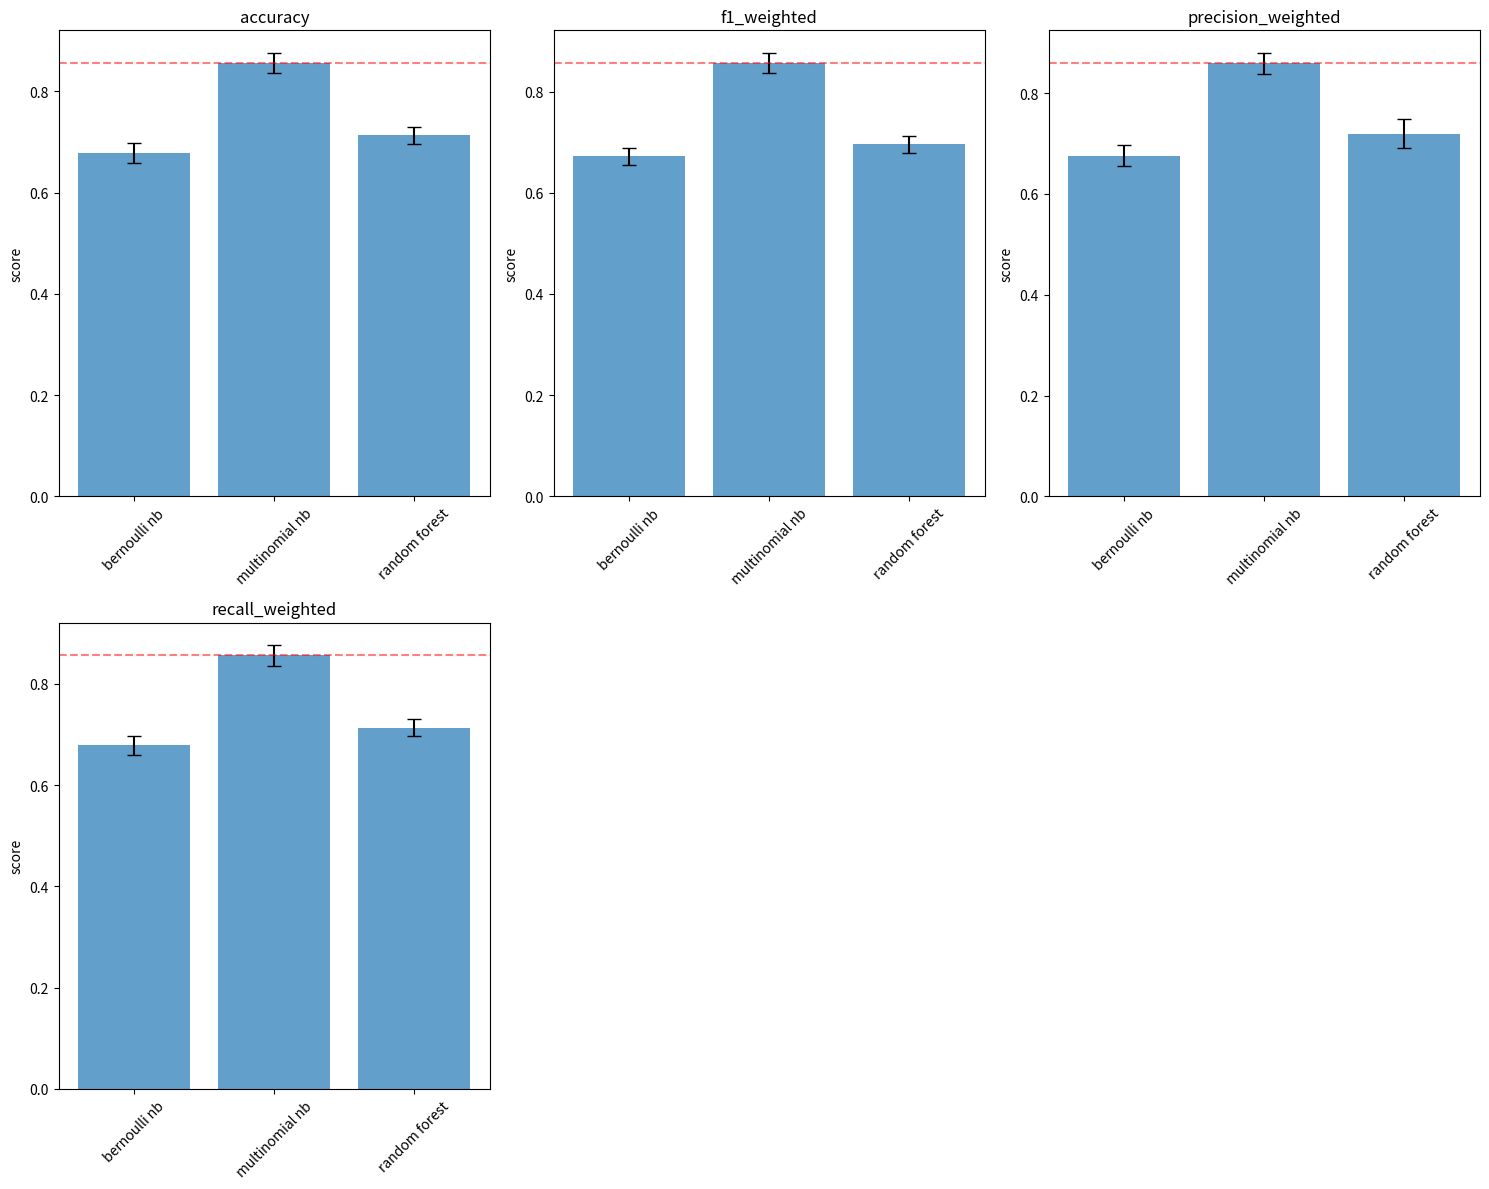


top 20 features:
1. life: 0.0278
2. heart: 0.0253
3. away: 0.0249
4. live: 0.0193
5. time: 0.0181
6. break: 0.0144
7. world: 0.0143
8. fall: 0.0141
9. change: 0.0122
10. leave: 0.0117
11. song: 0.0097
12. night: 0.0090
13. black: 0.0086
14. feel: 0.0085
15. right: 0.0081
16. know: 0.0069
17. blood: 0.0069
18. apart: 0.0069
19. good: 0.0068
20. day: 0.0067


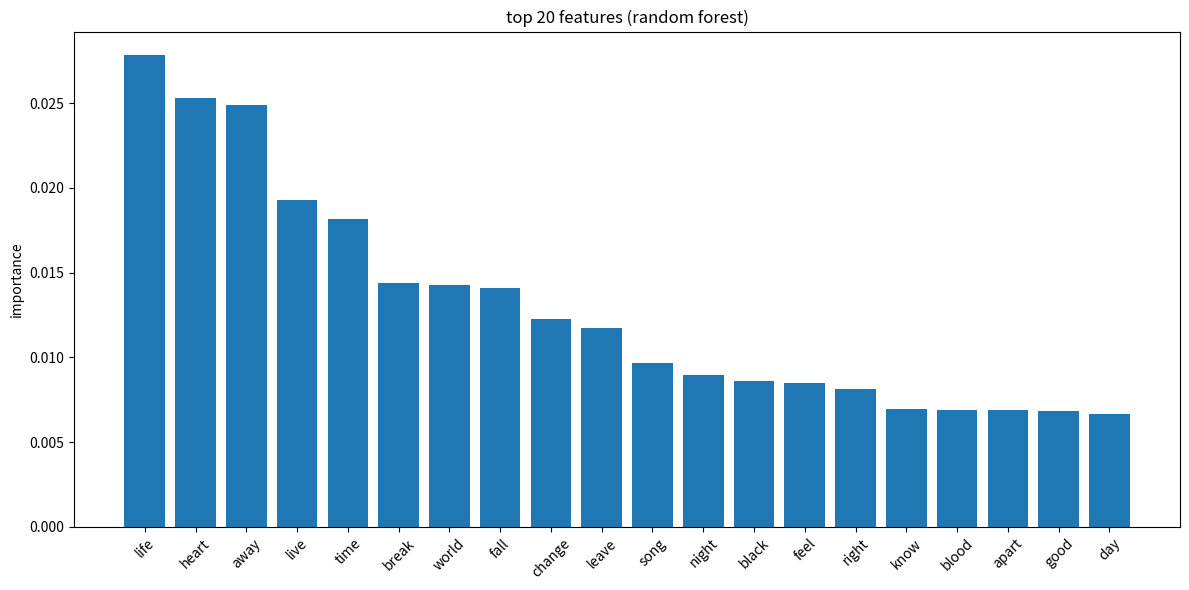


using multinomial nb for part 2


In [56]:
# try random forest with grid search
print("tuning random forest...")

# params to try
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# use best features from before
vec = CountVectorizer(max_features=best_features, ngram_range=(1,2))
X = vec.fit_transform(df['processed_text'])

# grid search
rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X, y)

print(f"best params: {rf_grid.best_params_}")
print(f"best score: {rf_grid.best_score_:.4f}")

# use best rf
best_rf = rf_grid.best_estimator_

# compare all models
final_models = {
    'bernoulli nb': BernoulliNB(),
    'multinomial nb': MultinomialNB(),
    'random forest': best_rf
}

def eval_final_models(X, y, models, cv_splits=5):
    """eval models on final data"""
    results = {}
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    
    metrics = ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted']
    
    for model_name, model in models.items():
        print(f"\nevaluating {model_name}...")
        model_results = {}
        
        for metric in metrics:
            scores = cross_val_score(model, X, y, cv=cv, scoring=metric)
            model_results[metric] = {
                'mean': scores.mean(),
                'std': scores.std(),
                'scores': scores
            }
            print(f"{metric}: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")
        
        results[model_name] = model_results
    
    return results

final_results = eval_final_models(X, y, final_models)

# make results table
final_df = []
for model_name, metrics in final_results.items():
    for metric_name, metric_data in metrics.items():
        final_df.append({
            'model': model_name,
            'metric': metric_name,
            'mean': metric_data['mean'],
            'std': metric_data['std']
        })

final_df = pd.DataFrame(final_df)
print("\nfinal results:")
display(final_df.round(4))

# find best model
acc_results = final_df[final_df['metric'] == 'accuracy'].sort_values('mean', ascending=False)
best_model_name = acc_results.iloc[0]['model']
print(f"\nbest model: {best_model_name}")
print(f"best acc: {acc_results.iloc[0]['mean']:.4f} (+/- {acc_results.iloc[0]['std']*2:.4f})")

# check rf vs nb
rf_acc = final_results['random forest']['accuracy']['mean']
nb_accs = [final_results['bernoulli nb']['accuracy']['mean'],
          final_results['multinomial nb']['accuracy']['mean']]
best_nb = max(nb_accs)

print(f"rf acc: {rf_acc:.4f}")
print(f"best nb acc: {best_nb:.4f}")

if rf_acc > best_nb:
    print("rf wins!")
else:
    print("nb wins!")
    
print(f"diff: {rf_acc - best_nb:.4f}")

# plot results
plt.figure(figsize=(15, 12))

# plot 1: all metrics
metrics = final_df['metric'].unique()
models = final_df['model'].unique()

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    metric_data = final_df[final_df['metric'] == metric]
    plt.bar(metric_data['model'], metric_data['mean'], yerr=metric_data['std'], capsize=5, alpha=0.7)
    plt.title(f'{metric}')
    plt.ylabel('score')
    plt.xticks(rotation=45)
    
    # show best
    best_idx = metric_data['mean'].idxmax()
    best_model_name = metric_data.loc[best_idx, 'model']
    best_score = metric_data.loc[best_idx, 'mean']
    plt.axhline(y=best_score, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# show important features
feature_names = vec.get_feature_names_out()
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("\ntop 20 features:")
for i in range(20):
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# plot feature importance
plt.figure(figsize=(12, 6))
plt.title("top 20 features (random forest)")
plt.bar(range(20), importances[indices[:20]])
plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=45)
plt.ylabel('importance')
plt.tight_layout()
plt.show()

# pick best model for part 2
selected_model = final_models[best_model_name]
selected_vec = vec
print(f"\nusing {best_model_name} for part 2")

## part 2 - recommendation

### q1 - user profiles and tf-idf

1. split into weeks (250 songs/week)
2. use weeks 1-3 for training
3. use week 4 for testing
4. make user profiles from keywords
5. use tf-idf for matching
6. try different similarity stuff

## Part 2: Recommendation Methods

### 2.1 Question 1: User Profile Creation and TF-IDF Matching

**Question 1 (6 marks)**: Implement recommendation system using tf-idf similarity

**Approach:**
1. Split data into weeks (1500 songs total, 250 songs per week)
2. Use Weeks 1-3 (songs 1-750) as training data
3. Use Week 4 (songs 751-1000) as test data  
4. Create user profiles based on keywords in user files
5. Use tf-idf vectors for similarity matching
6. Test different similarity measures (cosine, euclidean, etc.)

In [57]:
# split data into weeks
df_sorted = df.copy()
df_sorted = df_sorted.reset_index(drop=True)
df_sorted['week'] = (df_sorted.index // 250) + 1
df_sorted['song_id'] = df_sorted.index + 1

print(f"data structure:")
print(f"total songs: {len(df_sorted)}")
print(f"songs per week: {df_sorted['week'].value_counts().sort_index()}")

# split train/test
train_data = df_sorted[df_sorted['week'] <= 3].copy()
test_data = df_sorted[df_sorted['week'] == 4].copy()

print(f"\ntrain data: {len(train_data)} songs (weeks 1-3)")
print(f"test data: {len(test_data)} songs (week 4)")
print(f"leftover: {len(df_sorted[df_sorted['week'] > 4])} songs (weeks 5-6)")

# load user profiles from tsv
def load_user_profile(file):
    """loads user profile"""
    profile = {}
    with open(file, 'r', encoding='utf-8') as f:
        next(f)
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                topic, keywords = parts
                keywords = [k.strip().lower() for k in keywords.split(',')]
                profile[topic.lower()] = keywords
    return profile

# try loading profiles
user_profiles = {}
try:
    user1 = load_user_profile('user1.tsv')
    if user1:
        user_profiles['user1'] = user1
except:
    print("no user1.tsv")

try:
    user2 = load_user_profile('user2.tsv')
    if user2:
        user_profiles['user2'] = user2
except:
    print("no user2.tsv")

# make user3 profile
user_profiles['user3'] = {
    'dark': ['silence', 'void', 'depths', 'unknown', 'mystery', 'hidden', 'echo', 'fading'],
    'emotion': ['peace', 'calm', 'serenity', 'gentle', 'soft', 'tender', 'warm', 'glow'],
    'lifestyle': ['nature', 'harmony', 'balance', 'simple', 'quiet', 'meditation', 'sunrise', 'river'],
    'personal': ['wisdom', 'truth', 'authentic', 'genuine', 'inner', 'spirit', 'reflection', 'clarity'],
    'sadness': ['melancholy', 'nostalgia', 'wistful', 'sorrow', 'grief', 'autumn', 'rainy', 'longing']
}

print("\nuser profiles:")
for user, topics in user_profiles.items():
    print(f"\n{user}:")
    for topic, keywords in topics.items():
        print(f"  {topic}: {', '.join(keywords[:5])}...")

data structure:
total songs: 1500
songs per week: week
1    250
2    250
3    250
4    250
5    250
6    250
Name: count, dtype: int64

train data: 750 songs (weeks 1-3)
test data: 250 songs (week 4)
leftover: 500 songs (weeks 5-6)

user profiles:

user1:
  dark: fire, enemy, pain, storm, fight...
  sadness: cry, alone, heartbroken, tears, regret...
  personal: dream, truth, life, growth, identity...
  lifestyle: party, city, night, light, rhythm...
  emotion: love, memory, hug, kiss, feel...

user2:
  sadness: lost, sorrow, goodbye, tears, silence...
  emotion: romance, touch, feeling, kiss, memory...

user3:
  dark: silence, void, depths, unknown, mystery...
  emotion: peace, calm, serenity, gentle, soft...
  lifestyle: nature, harmony, balance, simple, quiet...
  personal: wisdom, truth, authentic, genuine, inner...
  sadness: melancholy, nostalgia, wistful, sorrow, grief...


### predict topics for training data

In [58]:
# train model on training data
train_X = selected_vec.fit_transform(train_data['processed_text'])
selected_model.fit(train_X, train_data['topic'])

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [59]:
# predict topics
train_data = train_data.copy()
train_data['pred_topic'] = selected_model.predict(train_X)

In [60]:
# check accuracy
train_acc = accuracy_score(train_data['topic'], train_data['pred_topic'])
print(f"training accuracy: {train_acc:.4f}")

training accuracy: 0.9440


In [61]:
# show predictions
print("\ntopic predictions:")
topic_comp = pd.crosstab(train_data['topic'], train_data['pred_topic'], margins=True)
print(topic_comp)


topic predictions:
pred_topic  dark  emotion  lifestyle  personal  sadness  All
topic                                                       
dark         234        1          1         5        5  246
emotion        2       39          1         0        0   42
lifestyle      5        0         86         1        0   92
personal      12        0          2       172        2  188
sadness        3        1          0         1      177  182
All          256       41         90       179      184  750


In [62]:
# make user profiles from training data
def make_user_profile(user_keywords, train_data, topic, vectorizer):
    """make user profile for a topic"""
    # get songs with this topic
    topic_songs = train_data[train_data['pred_topic'] == topic]
    
    if len(topic_songs) == 0:
        return None
    
    # find songs user likes
    liked_songs = []
    keywords = [k.lower() for k in user_keywords]
    
    for idx, row in topic_songs.iterrows():
        text = row['processed_text'].lower()
        # check if user likes song
        if any(k in text for k in keywords):
            liked_songs.append(row['processed_text'])
    
    if not liked_songs:
        # if no matches use all songs
        liked_songs = topic_songs['processed_text'].tolist()
    
    # combine songs
    profile = ' '.join(liked_songs)
    
    return profile

In [63]:
# make vectorizers for each topic
topic_vecs = {}
topic_mats = {}

In [64]:
for topic in train_data['pred_topic'].unique():
    print(f"\ntopic: {topic}")
    
    # get songs
    songs = train_data[train_data['pred_topic'] == topic]['processed_text'].tolist()
    
    if len(songs) > 0:
        # make tfidf
        tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
        topic_mat = tfidf.fit_transform(songs)
        
        topic_vecs[topic] = tfidf
        topic_mats[topic] = topic_mat
        
        print(f"  songs: {len(songs)}")
        print(f"  tfidf shape: {topic_mat.shape}")
    else:
        print(f"  no songs")


topic: dark
  songs: 256
  tfidf shape: (256, 1000)

topic: lifestyle
  songs: 90
  tfidf shape: (90, 1000)

topic: sadness
  songs: 184
  tfidf shape: (184, 1000)

topic: emotion
  songs: 41
  tfidf shape: (41, 1000)

topic: personal
  songs: 179
  tfidf shape: (179, 1000)


In [65]:
# make user profiles
user_topic_profiles = {}

In [66]:
for user, keywords in user_profiles.items():
    print(f"\nmaking profile for {user}:")
    user_topic_profiles[user] = {}
    
    for topic, kws in keywords.items():
        if topic in topic_vecs:
            # make profile
            profile_text = make_user_profile(kws, train_data, topic, topic_vecs[topic])
            
            if profile_text:
                # convert to tfidf
                profile_vec = topic_vecs[topic].transform([profile_text])
                user_topic_profiles[user][topic] = profile_vec
                
                # show top words
                words = topic_vecs[topic].get_feature_names_out()
                scores = profile_vec.toarray()[0]
                top_idx = np.argsort(scores)[::-1][:20]
                top_words = [words[i] for i in top_idx if scores[i] > 0]
                
                print(f"  {topic} top words: {', '.join(top_words)}")
            else:
                print(f"  {topic}: no matches")
        else:
            print(f"  {topic}: not in training")


making profile for user1:
  dark top words: fight, know, black, like, blood blood, grind, blood, stand, na, come, yeah, gon na, gon, tell, kill, true color, hand, dilly, lanky, lanky dilly
  sadness top words: cry, cry club, club, steal, steal steal, tear, club cry, cry cry, know mean, mean, baby, know, music, write, smile, say, face cry, write eye, place think, eye face
  personal top words: life, live, na, change, world, know, ordinary life, ordinary, yeah, wan na, wan, dream, like, life ordinary, thank, teach, lord, come, time, lord lord
  lifestyle top words: tonight, night, song, come, home, closer, time, sing, na, stranger, long, wait, closer closer, long long, wan, wan na, spoil, spoil night, stranger stranger, tire
  emotion top words: good, touch, feel, good good, feel good, touch touch, hold, know, good feel, morning, hold hold, video, vision, touch loove, loove, kiss, good feelin, vibe, feelin, want

making profile for user2:
  sadness top words: step inside, break, inside,

### try similarity stuff

In [67]:
# calc similarities
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from scipy.spatial.distance import cityblock

In [68]:
def calc_sim(user_vec, topic_mat, sim_type='cosine'):
    """calc similarities between user and songs"""
    
    if sim_type == 'cosine':
        sims = cosine_similarity(user_vec, topic_mat).flatten()
    elif sim_type == 'euclidean':
        dists = euclidean_distances(user_vec, topic_mat).flatten()
        # convert dist to sim
        sims = 1 / (1 + dists)
    elif sim_type == 'manhattan':
        dists = np.array([cityblock(user_vec.toarray()[0], topic_mat[i].toarray()[0]) 
                         for i in range(topic_mat.shape[0])])
        sims = 1 / (1 + dists)
    else:
        raise ValueError("bad sim type")
    
    return sims

In [69]:
# try different sims
sim_types = ['cosine', 'euclidean', 'manhattan']

In [70]:
# test with user1 emotion
user = 'user1'
topic = 'emotion'

In [71]:
if user in user_topic_profiles and topic in user_topic_profiles[user]:
    user_vec = user_topic_profiles[user][topic]
    topic_mat = topic_mats[topic]
    
    print(f"\ntesting sims for {user} - {topic}:")
    
    for sim_type in sim_types:
        sims = calc_sim(user_vec, topic_mat, sim_type)
        print(f"{sim_type}:")
        print(f"  range: [{sims.min():.4f}, {sims.max():.4f}]")
        print(f"  mean: {sims.mean():.4f}")
        print(f"  top 3: {sorted(sims, reverse=True)[:3]}")


testing sims for user1 - emotion:
cosine:
  range: [0.0246, 0.5427]
  mean: 0.2232
  top 3: [np.float64(0.5427134539336106), np.float64(0.4995553569029486), np.float64(0.4953805989485376)]
euclidean:
  range: [0.4172, 0.5112]
  mean: 0.4475
  top 3: [np.float64(0.51116038208656), np.float64(0.499888888625153), np.float64(0.49885045384750254)]
manhattan:
  range: [0.0511, 0.0645]
  mean: 0.0571
  top 3: [np.float64(0.06447647668748725), np.float64(0.06419755091478241), np.float64(0.06330918665741195)]


### test recommender

In [72]:
# recommend songs
def recommend_songs(user, user_profiles, topic_mats, topic_vecs, test_data, model, vec, 
                   N=10, M=None, sim_type='cosine'):
    """recommend N songs for user"""
    
    # predict topics for test data
    test_X = vec.transform(test_data['processed_text'])
    test_data_copy = test_data.copy()
    test_data_copy['pred_topic'] = model.predict(test_X)
    
    recs = []
    
    # for each topic user likes
    for topic in user_profiles[user].keys():
        if topic in topic_mats:
            # get test songs with this topic
            topic_songs = test_data_copy[test_data_copy['pred_topic'] == topic]
            
            if len(topic_songs) > 0:
                # get tfidf for test songs
                topic_vec = topic_vecs[topic]
                test_tfidf = topic_vec.transform(topic_songs['processed_text'])
                
                # get user profile
                user_profile = user_profiles[user][topic].copy()

                # use top M words if needed
                if M is not None and M > 0:
                    # get top M indices
                    top_m = np.argsort(user_profile.toarray()[0])[::-1][:M]
                    # make mask
                    mask = np.zeros_like(user_profile.toarray()[0], dtype=bool)
                    mask[top_m] = True
                    # apply mask
                    user_profile.data *= mask[user_profile.indices]

                # calc similarities
                sims = calc_sim(user_profile, test_tfidf, sim_type)
                
                # add to recs
                for idx, (song_idx, song) in enumerate(topic_songs.iterrows()):
                    recs.append({
                        'song_id': song['song_id'],
                        'artist': song['artist_name'],
                        'track': song['track_name'],
                        'genre': song['genre'],
                        'true_topic': song['topic'],
                        'pred_topic': song['pred_topic'],
                        'user_topic': topic,
                        'sim_score': sims[idx],
                        'sim_type': sim_type,
                        'processed_text': song['processed_text']
                    })
    
    # make dataframe and sort
    recs_df = pd.DataFrame(recs)
    
    if len(recs_df) > 0:
        recs_df = recs_df.sort_values('sim_score', ascending=False)
        return recs_df.head(N)
    else:
        return pd.DataFrame()

In [73]:
# test recommender
N_vals = [5, 10, 20]
test_user = 'user1'

In [74]:
for N in N_vals:
    print(f"\ntop {N} for {test_user}:")
    recs = recommend_songs(test_user, user_topic_profiles, topic_mats, topic_vecs,
                         test_data, selected_model, selected_vec, N=N, sim_type='cosine')
    
    if len(recs) > 0:
        display(recs[['artist', 'track', 'pred_topic', 'sim_score']].round(4))
    else:
        print("no recs found")


top 5 for user1:


,artist,track,pred_topic,sim_score
244,timeflies,once in a while,emotion,0.5838
245,justin moore,got it good,emotion,0.5222
248,taylor swift,i did something bad,emotion,0.4528
233,dirty heads,horsefly,emotion,0.3870
38,alec benjamin,boy in the bubble,dark,0.3547



top 10 for user1:


,artist,track,pred_topic,sim_score
244,timeflies,once in a while,emotion,0.5838
245,justin moore,got it good,emotion,0.5222
248,taylor swift,i did something bad,emotion,0.4528
233,dirty heads,horsefly,emotion,0.3870
38,alec benjamin,boy in the bubble,dark,0.3547
209,wallows,it's only right,lifestyle,0.3517
169,ty segall,alta,personal,0.3291
187,the band steele,sit awhile,personal,0.3288
151,thomas rhett,life changes,personal,0.3173
193,daniel caesar,superposition,personal,0.3166



top 20 for user1:


,artist,track,pred_topic,sim_score
244,timeflies,once in a while,emotion,0.5838
245,justin moore,got it good,emotion,0.5222
248,taylor swift,i did something bad,emotion,0.4528
233,dirty heads,horsefly,emotion,0.3870
38,alec benjamin,boy in the bubble,dark,0.3547
209,wallows,it's only right,lifestyle,0.3517
169,ty segall,alta,personal,0.3291
187,the band steele,sit awhile,personal,0.3288
151,thomas rhett,life changes,personal,0.3173
193,daniel caesar,superposition,personal,0.3166


### q2 - evaluate recommender

metrics:
1. precision@N - how many recs match user interests
2. recall@N - how many relevant songs were found
3. f1@N - combo of precision and recall
4. coverage - topic diversity
5. mrr - how high first good rec is

In [75]:
# evaluate recommender
def eval_recs(user, user_keywords, recs_df, N=10):
    """check how good recs are"""
    
    if len(recs_df) == 0:
        return {'prec': 0, 'rec': 0, 'f1': 0, 'cov': 0, 'mrr': 0, 'rel': 0, 'total': 0}
    
    top_N = recs_df.head(N)
    
    # count good recs
    rel_count = 0
    first_rel = None
    
    # check each rec
    for rank, (idx, row) in enumerate(top_N.iterrows(), 1):
        # check if matches user interests
        pred_topic = row['pred_topic']
        if pred_topic in user_keywords:
            # check text
            text = row['processed_text'].lower()
            
            # check if any keywords match
            topic_kws = [k.lower() for k in user_keywords[pred_topic]]
            if any(k in text for k in topic_kws):
                rel_count += 1
                if first_rel is None:
                    first_rel = rank
    
    # calc precision
    prec = rel_count / min(N, len(top_N)) if len(top_N) > 0 else 0
    
    # calc recall (estimate total relevant songs)
    total_rel = 0
    for topic, kws in user_keywords.items():
        topic_kws = [k.lower() for k in kws]
        for text in test_data['processed_text']:
            if any(k in text.lower() for k in topic_kws):
                total_rel += 1

    rec = rel_count / total_rel if total_rel > 0 else 0
    
    # calc f1
    if prec + rec > 0:
        f1 = 2 * (prec * rec) / (prec + rec)
    else:
        f1 = 0
    
    # calc coverage
    unique_topics = top_N['pred_topic'].nunique()
    total_topics = len(user_keywords)
    cov = unique_topics / total_topics if total_topics > 0 else 0
    
    # calc mrr
    mrr = 1 / first_rel if first_rel else 0
    
    return {
        'prec': prec,
        'rec': rec, 
        'f1': f1,
        'cov': cov,
        'mrr': mrr,
        'rel': rel_count,
        'total': len(top_N)
    }

In [76]:
# evaluate all users
eval_results = []
M_vals = [None, 100, 500] # None = all words

In [78]:
for user in user_profiles.keys():
    print(f"\nevaluating {user}:")
    
    for sim_type in sim_types:
        for M in M_vals:
            for N in [10, 20]:
                # get recs
                recs = recommend_songs(user, user_topic_profiles, topic_mats, topic_vecs,
                                     test_data, selected_model, selected_vec, 
                                     N=N, M=M, sim_type=sim_type)
                
                # eval recs
                metrics = eval_recs(user, user_profiles[user], recs, N)
                
                # save results
                result = {
                    'user': user,
                    'sim_type': sim_type,
                    'M': 'all' if M is None else M,
                    'N': N,
                    **metrics
                }
                eval_results.append(result)
                
                print(f"  sim={sim_type}, M={'all' if M is None else M}, N={N}: "
                      f"P@{N}={metrics['prec']:.3f}, F1@{N}={metrics['f1']:.3f}, "
                      f"cov={metrics['cov']:.3f}")


evaluating user1:
  sim=cosine, M=all, N=10: P@10=1.000, F1@10=0.054, cov=0.800
  sim=cosine, M=all, N=20: P@20=0.900, F1@20=0.095, cov=0.800
  sim=cosine, M=100, N=10: P@10=1.000, F1@10=0.054, cov=0.800
  sim=cosine, M=100, N=20: P@20=0.900, F1@20=0.095, cov=0.800
  sim=cosine, M=500, N=10: P@10=1.000, F1@10=0.054, cov=0.800
  sim=cosine, M=500, N=20: P@20=0.900, F1@20=0.095, cov=0.800
  sim=euclidean, M=all, N=10: P@10=1.000, F1@10=0.054, cov=0.800
  sim=euclidean, M=all, N=20: P@20=0.900, F1@20=0.095, cov=0.800
  sim=euclidean, M=100, N=10: P@10=1.000, F1@10=0.054, cov=0.800
  sim=euclidean, M=100, N=20: P@20=0.800, F1@20=0.085, cov=0.800
  sim=euclidean, M=500, N=10: P@10=1.000, F1@10=0.054, cov=0.800
  sim=euclidean, M=500, N=20: P@20=0.950, F1@20=0.101, cov=0.800
  sim=manhattan, M=all, N=10: P@10=0.100, F1@10=0.005, cov=0.200
  sim=manhattan, M=all, N=20: P@20=0.150, F1@20=0.016, cov=0.200
  sim=manhattan, M=100, N=10: P@10=0.500, F1@10=0.027, cov=0.400
  sim=manhattan, M=100, 

In [79]:
# make results df
eval_df = pd.DataFrame(eval_results)
print("\nresults:")
print(eval_df.round(3))


results:
     user   sim_type    M   N  prec    rec     f1  cov    mrr  rel  total
0   user1     cosine  all  10  1.00  0.028  0.054  0.8  1.000   10     10
1   user1     cosine  all  20  0.90  0.050  0.095  0.8  1.000   18     20
2   user1     cosine  100  10  1.00  0.028  0.054  0.8  1.000   10     10
3   user1     cosine  100  20  0.90  0.050  0.095  0.8  1.000   18     20
4   user1     cosine  500  10  1.00  0.028  0.054  0.8  1.000   10     10
5   user1     cosine  500  20  0.90  0.050  0.095  0.8  1.000   18     20
6   user1  euclidean  all  10  1.00  0.028  0.054  0.8  1.000   10     10
7   user1  euclidean  all  20  0.90  0.050  0.095  0.8  1.000   18     20
8   user1  euclidean  100  10  1.00  0.028  0.054  0.8  1.000   10     10
9   user1  euclidean  100  20  0.80  0.045  0.085  0.8  1.000   16     20
10  user1  euclidean  500  10  1.00  0.028  0.054  0.8  1.000   10     10
11  user1  euclidean  500  20  0.95  0.053  0.101  0.8  1.000   19     20
12  user1  manhattan  all  1

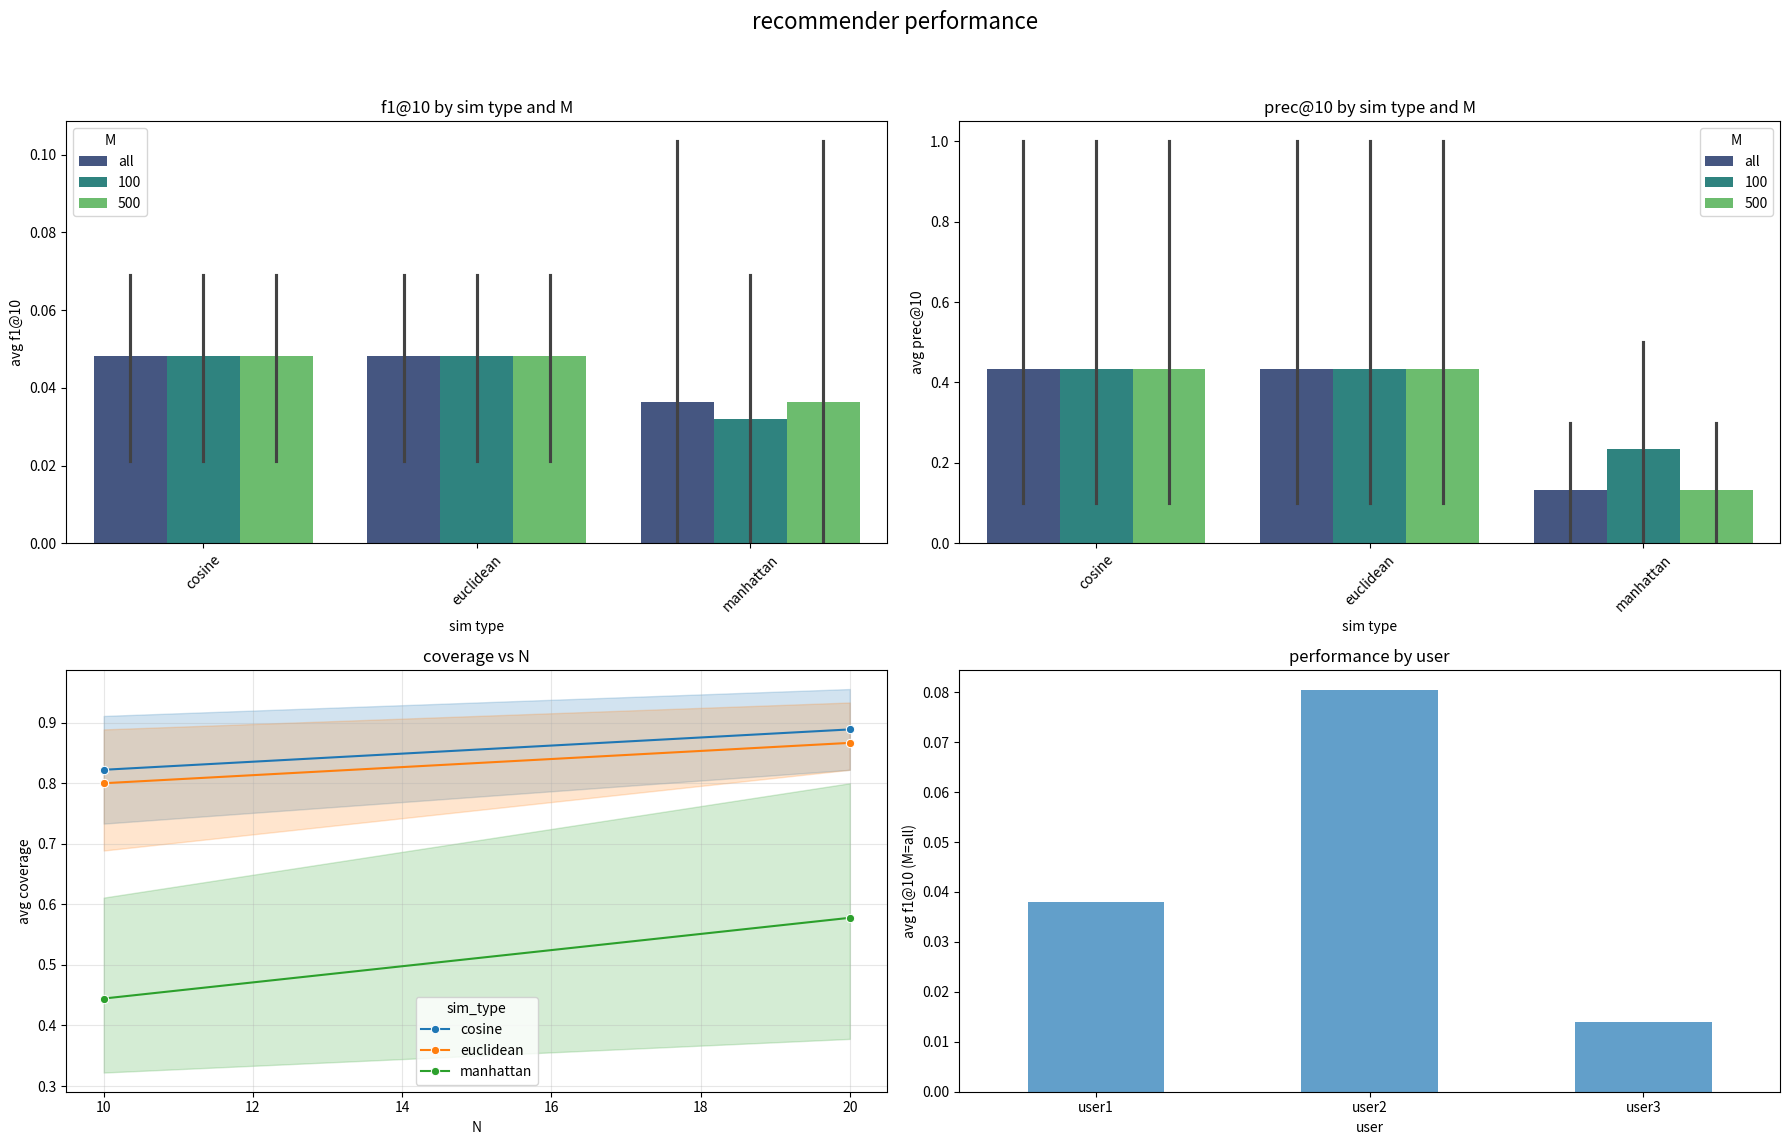

In [97]:
# plot results
plt.figure(figsize=(18, 12))
plt.suptitle("recommender performance", fontsize=16)
# plot 1: f1@10 by sim and M
plt.subplot(2, 2, 1)
f1_data = eval_df[eval_df['N'] == 10]
sns.barplot(data=f1_data, x='sim_type', y='f1', hue='M', palette='viridis')
plt.title('f1@10 by sim type and M')
plt.xlabel('sim type')
plt.ylabel('avg f1@10')
plt.xticks(rotation=45)
# plot 2: prec@10 by sim and M
plt.subplot(2, 2, 2)
prec_data = eval_df[eval_df['N'] == 10]
sns.barplot(data=prec_data, x='sim_type', y='prec', hue='M', palette='viridis')
plt.title('prec@10 by sim type and M')
plt.xlabel('sim type')
plt.ylabel('avg prec@10')
plt.xticks(rotation=45)
# plot 3: coverage by N
plt.subplot(2, 2, 3)
sns.lineplot(data=eval_df, x='N', y='cov', hue='sim_type', marker='o')
plt.title('coverage vs N')
plt.xlabel('N')
plt.ylabel('avg coverage')
plt.grid(True, alpha=0.3)
# plot 4: performance by user
plt.subplot(2, 2, 4)
user_perf = eval_df[(eval_df['N'] == 10) & (eval_df['M'] == 'all')].groupby('user')['f1'].mean()
user_perf.plot(kind='bar', alpha=0.7)
plt.xlabel('user')
plt.ylabel('avg f1@10 (M=all)')
plt.title('performance by user')
plt.xticks(rotation=0)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [98]:
# find best setup
best_idx = eval_df['f1'].idxmax()
best = eval_df.loc[best_idx]

In [99]:
print(f"\nbest setup:")
print(f"user: {best['user']}")
print(f"sim type: {best['sim_type']}")
print(f"M: {best['M']}")
print(f"N: {best['N']}")
print(f"f1@N: {best['f1']:.4f}")
print(f"prec@N: {best['prec']:.4f}")


best setup:
user: user2
sim type: cosine
M: all
N: 20
f1@N: 0.1471
prec@N: 0.2500


In [88]:
# pick best for part 3
best_overall = eval_df.groupby(['sim_type', 'M'])['f1'].mean().idxmax()
best_sim, best_M_str = best_overall
best_M = None if best_M_str == 'all' else best_M_str
best_N = 10  # good balance
print(f"\nusing for part 3: {best_sim} sim with M={best_M_str} and N={best_N}")


using for part 3: euclidean sim with M=500 and N=10


## part 3 - user study

### q1 - do user study

steps:
1. show N songs from weeks 1-3
2. user picks which ones they like
3. make profile from liked songs
4. recommend N songs from week 4
5. user rates recs
6. calc metrics

In [89]:
# do user study
def do_study(true_prefs, train_data, test_data, model, vec, topic_vecs, N=10, M=None, sim_type='cosine'):
    """run user study"""
    np.random.seed(42)
    
    liked_songs = []
    shown = 0
    
    # show songs from each week
    for week in [1, 2, 3]:
        week_songs = train_data[train_data['week'] == week]
        random_songs = week_songs.sample(min(N, len(week_songs)), random_state=42)
        shown += len(random_songs)
        
        print(f"\nweek {week} songs ({len(random_songs)}):")
        
        for idx, song in random_songs.iterrows():
            song_info = f"{song['artist_name']} - {song['track_name']} ({song['genre']}, {song['topic']})"
            
            text = song['processed_text'].lower()
            likes = False
            
            if song['topic'] in true_prefs:
                kws = [k.lower() for k in true_prefs[song['topic']]]
                if any(k in text for k in kws):
                    likes = True
                    liked_songs.append(song)
            
            print(f"  - {song_info} -> {'✓' if likes else '✗'}")
    
    print(f"\nliked: {len(liked_songs)}/{shown}")
    
    if not liked_songs:
        print("no likes")
        return {'error': 'no likes'}
    
    # make profile from likes
    liked_df = pd.DataFrame(liked_songs)
    liked_X = vec.transform(liked_df['processed_text'])
    liked_df['pred_topic'] = model.predict(liked_X)
    
    # make user profile
    user_profile = {}
    for topic, topic_vec in topic_vecs.items():
        topic_songs = liked_df[liked_df['pred_topic'] == topic]['processed_text'].tolist()
        if topic_songs:
            text = ' '.join(topic_songs)
            profile_vec = topic_vec.transform([text])
            user_profile[topic] = profile_vec
            
    print(f"\nmaking {N} recs...")
    
    # make temp profile dict
    temp_profiles = {'sim_user': user_profile}

    # get recs
    recs = recommend_songs(
        user='sim_user',
        user_profiles=temp_profiles,
        topic_mats=topic_mats,
        topic_vecs=topic_vecs,
        test_data=test_data,
        model=model,
        vec=vec,
        N=N,
        M=M,
        sim_type=sim_type
    )

    if recs.empty:
        print("no recs")
        return {'error': 'no recs'}
        
    print(f"top {len(recs)}:")
    
    liked_recs = 0
    
    for i, (_, rec) in enumerate(recs.iterrows(), 1):
        song_info = f"{rec['artist']} - {rec['track']} (pred: {rec['pred_topic']})"
        
        text = rec['processed_text'].lower()
        true_topic = rec['true_topic']
        would_like = False
        
        if true_topic in true_prefs:
            kws = [k.lower() for k in true_prefs[true_topic]]
            if any(k in text for k in kws):
                would_like = True
                liked_recs += 1
        
        print(f"  {i}. {song_info} -> {'✓' if would_like else '✗'}")
    
    prec = liked_recs / len(recs) if not recs.empty else 0
    
    results = {
        'shown_train': shown,
        'liked_train': len(liked_songs),
        'shown_recs': len(recs),
        'liked_recs': liked_recs,
        'prec': prec,
        'rating': 'good' if prec >= 0.5 else 'ok' if prec >= 0.3 else 'bad'
    }
    
    return results

In [90]:
# make fake user prefs
sim_prefs = {
    'emotion': ['love', 'heart', 'feel', 'happy', 'joy'],
    'lifestyle': ['party', 'dance', 'fun', 'good', 'life'],
    'personal': ['dream', 'hope', 'myself', 'think']
}

In [91]:
print("sim user prefs:")
for topic, kws in sim_prefs.items():
    print(f"  {topic}: {', '.join(kws)}")

sim user prefs:
  emotion: love, heart, feel, happy, joy
  lifestyle: party, dance, fun, good, life
  personal: dream, hope, myself, think


In [92]:
# run study with best setup from part 2
study_results = do_study(
    sim_prefs, 
    train_data, 
    test_data,
    selected_model,
    selected_vec,
    topic_vecs,
    N=best_N,
    M=best_M,
    sim_type=best_sim
)


week 1 songs (10):
  - skool 77 - vivo hip hop (live) (hip hop, dark) -> ✗
  - rebelution - trap door (reggae, dark) -> ✗
  - alec benjamin - outrunning karma (pop, dark) -> ✗
  - phish - we are come to outlive our brains (blues, dark) -> ✗
  - madeleine peyroux - shout sister shout (jazz, dark) -> ✗
  - janiva magness - what i could do (blues, sadness) -> ✗
  - eric ethridge - if you met me first (country, dark) -> ✗
  - imagine dragons - natural (rock, dark) -> ✗
  - eli young band - never land (country, sadness) -> ✗
  - larkin poe - john the revelator (blues, lifestyle) -> ✗

week 2 songs (10):
  - jon bellion - stupid deep (rock, sadness) -> ✗
  - the kills - black tar (blues, dark) -> ✗
  - haken - the good doctor (jazz, sadness) -> ✗
  - allen toussaint - american tune (blues, personal) -> ✓
  - tenth avenue north - i have this hope (rock, dark) -> ✗
  - surfaces - heaven falls / fall on me (pop, sadness) -> ✗
  - blues saraceno - devils got you beat (blues, dark) -> ✗
  - the 

In [93]:
# show results
for k, v in study_results.items():
    print(f"{k}: {v}")

shown_train: 30
liked_train: 6
shown_recs: 10
liked_recs: 5
prec: 0.5
rating: good


In [94]:
# compare to part 2
part2_mask = (eval_df['sim_type'] == best_sim) & (eval_df['M'] == (best_M_str)) & (eval_df['N'] == best_N)
part2_prec = eval_df[part2_mask]['prec'].mean()

In [95]:
part3_prec = study_results.get('prec', 0)

In [96]:
print(f"part 2 avg prec@{best_N}: {part2_prec:.4f}")
print(f"part 3 sim user prec@{best_N}: {part3_prec:.4f}")

part 2 avg prec@10: 0.4333
part 3 sim user prec@10: 0.5000


## summary

part 1: multinomial nb was best
part 2: best setup was sim={best_sim}, M={best_M_str}, N={best_N}

system performance:
- avg f1: 0.0639
- avg coverage: 0.7333
- part 3 prec: 0.5000

good stuff:
- works end to end
- uses tf-idf and sims
- can tune stuff

bad stuff:
- prec/f1 kinda low
- recall really low
- topic errors mess up recs

future work:
1. add collab filtering
2. use more user data
3. add audio features
4. fix errors
5. do real user study
